# Churn 2.0 Project

In [1]:
# import all the required dependecnies and modules

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
#sns.set_theme(style="whitegrid")
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import time
import pickle
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud import bigquery_storage_v1
import string
import xgboost as xgb

import churn_preprocessing_v5 as cpp
import churn_modeling as cm

## Read the training data for specific month from BQ

In [2]:
# Set up the connection to GBG
bqconn = cpp.bqConnect('alticeusa-am-b639e404289b.json', 'alticeusa-am')

# Get the training data for required month (EAST residential customers)
raw_data_sql = '''select * from eds_churn.t_ds_fixed_churn_train where month_id = '202202' and upper(cust_class_fs_type_desc) = 'RESIDENTIAL' and metro_area_id = 401 '''
raw_data_res = bqconn.fetch_data(raw_data_sql)

raw_data_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2912819 entries, 0 to 2912818
Columns: 272 entries, month_id to OUTCOME_false_mover_flag
dtypes: datetime64[ns](18), float64(55), int64(23), object(176)
memory usage: 5.9+ GB


In [6]:
# raw_data_res.to_pickle('Data/raw_data_res.pkl')

In [2]:
# raw_data_res = pd.read_pickle("Data/raw_data_res.pkl")  
# raw_data_res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4634832 entries, 0 to 5016624
Columns: 357 entries, month_id to OUTCOME_BAU_pending_mover
dtypes: datetime64[ns](15), float64(87), int64(18), object(237)
memory usage: 12.4+ GB


In [3]:
raw_data_res.head().T

,0,1,2,3,4
month_id,202202,202202,202202,202202,202202
curr_dt,2022-02-28,2022-02-28,2022-02-28,2022-02-28,2022-02-28
chc_id,784824197902,787004843007,786986075003,786904108703,788113734802
corp,7848,7870,7869,7869,7881
house,241979,48430,860750,41087,137348
cust,2,7,3,3,2
account_id,7340459,18001013,11279422,16160593,4675604
house_id,3420750,4521066,4379105,4336840,5746100
fta,88,25,10,7,6
node_latitude,40.789187,40.904881,41.01853,41.004987,41.574269


## Create target variable by combining Ord. Vol disco and FM 

In [4]:
raw_data_res["OUTCOME_vol_FM"] = np.where((raw_data_res["OUTCOME_VOL_DISCO_NXT_4MTH"] == 1) | (raw_data_res["OUTCOME_false_mover_flag"] == 1), 1, 0)

print('Pending Voluntary disconnects : ', raw_data_res['OUTCOME_VOL_DISCO_NXT_4MTH'].sum())
print('False Movers                  : ',raw_data_res['OUTCOME_false_mover_flag'].sum())
print('Pend Vol disconnects + False Movers : ', raw_data_res["OUTCOME_vol_FM"].sum())

Pending Voluntary disconnects :  44466
False Movers                  :  20615.0
Pend Vol disconnects + False Movers :  64705


## Extract only below useful columns for modelling

In [5]:
target_col = ['OUTCOME_vol_FM']

cat_cols = [
'head_end_desc', 'local_market_segment', 
'metro_area_desc', 'product_class_desc', 'cust_equip_class', 
'ecohort_code_desc', 'ecohort_income_range_desc', 'ecohort_age_range_desc', 'ecohort_spending_type_desc', 'ecohort_credit_line_type_desc', 'ecohort_credit_usage_type_desc', 'archetype_desc', 
'ebill_status_desc',
'agent_last_dept',   
'agent_repeat_1_prevDept', 'agent_repeat_1_prevInteractionReason', 'agent_repeat_2_prevDept', 
'agent_repeat_2_prevInteractionReason', 'agent_repeat_3_prevInteractionReason', 'agent_repeat_3_prevDept', 
'ivr_last_dept', 'ivr_last_interactionReason', 'ivr_last_ivrInteractionEndResult', 
'ivr_repeat_1_prevDept', 'ivr_repeat_1_prevInteractionReason',
'ivr_repeat_2_prevDept', 'ivr_repeat_2_prevInteractionReason',
'ivr_repeat_3_prevDept', 'ivr_repeat_3_prevInteractionReason',
'speed_m0', 'speed_m1', 'speed_m2', 'speed_m3', 'speed_m4', 
'curr_video_tier_desc_m0', 'curr_video_tier_desc_m1', 'curr_video_tier_desc_m2', 'curr_video_tier_desc_m3', 'curr_video_tier_desc_m4', 
'curr_ov_tier_desc_m0', 'curr_ov_tier_desc_m1', 'curr_ov_tier_desc_m2', 'curr_ov_tier_desc_m3', 'curr_ov_tier_desc_m4', 
'hbo_svod_new_m1', 'hbo_svod_new_m2', 'hbo_svod_new_m3',
'max_svod_m1', 'max_svod_m2', 'max_svod_m3', 
'ool_offer_group_v2_desc_m0', 'ool_offer_group_v2_desc_m1', 'ool_offer_group_v2_desc_m2', 'ool_offer_group_v2_desc_m3', 'ool_offer_group_v2_desc_m4',
'oolpromo_rng_m0',             
'ov_offer_group_v2_desc_m0', 'ov_offer_group_v2_desc_m1', 'ov_offer_group_v2_desc_m2', 'ov_offer_group_v2_desc_m3', 'ov_offer_group_v2_desc_m4',   
'ovpromo_rng_m0',            
'stz_enc_svod_m1', 'stz_enc_svod_m2', 'stz_enc_svod_m3', 
'video_offer_group_desc_m0', 'video_offer_group_desc_m1', 'video_offer_group_desc_m2', 'video_offer_group_desc_m3', 'video_offer_group_desc_m4', 
'service_visit_1_tc_problem_code_desc', 'service_visit_1_tc_fix_code_desc', 'service_visit_2_tc_problem_code_desc', 'service_visit_2_tc_fix_code_desc', 
'service_visit_3_tc_problem_code_desc', 'service_visit_3_tc_fix_code_desc', 
'videopromo_rng_m0']           


num_cols = [
'analog_revenue',  'iptel_revenue', 'ool_revenue',  'dvr_revenue',
'auto_ind', 
'agent_abandoned_standard_7day', 'agent_abandoned_7day', 'agent_offered_7day', 'agent_accepted_7day', 'agent_abandoned_standard_30day', 'agent_abandoned_30day', 'agent_offered_30day', 'agent_accepted_30day',
'agent_repeat_calls_30day', 'ivr_calls_7day', 'ivr_calls_30day', 'ivr_repeat_calls_30day', 
'service_visits_7day', 'service_visits_30day', 'service_visits_90day', 
'outages_90day', 'outages_60day', 'outages_30day', 
'rate_event_count_60day', 
'promo_rolloff_count_60day', 
'FAILSTAT_OFFLINEEVT', 'FAILSTAT_DHCP_MACADDR', 'FAILSTAT_WIFI_REBOOT_COUNT', 'FAILSTAT_WIFI_QOE_HOME_30',
# 'acu_ool_usage_down_mb_m1', 'acu_ool_usage_up_mb_m1', 'acu_ool_usage_down_mb_m2', 'acu_ool_usage_up_mb_m2', 
# 'avg_sports_sc_rev_m1_m6', 
'baserev_m0', 'baserev_m1', 'baserev_m2', 'baserev_m3', 'baserev_m4', 'baserev_m5', 'baserev_m6', 
'cust_svc_bill_agent_offered_m0', 'cust_svc_bill_agent_offered_m1', 'cust_svc_bill_agent_offered_m2', 'cust_svc_bill_agent_offered_m3', 'cust_svc_bill_agent_offered_m4', 'cust_svc_bill_agent_offered_m5', 'cust_svc_bill_agent_offered_m6', 
'tot_ool_gb_all_m1', 'tot_ool_gb_all_m2',
# 'mb_total_usage1', 'mb_total_usage2', 
'roll_off_lift_m0' , 'roll_off_lift_m1', 'roll_off_lift_m2', 'roll_off_lift_m3', 'roll_off_lift_m4',              
'tot_retention_contacts_m0', 'tot_retention_contacts_m1', 'tot_retention_contacts_m2', 'tot_retention_contacts_m3', 'tot_retention_contacts_m4', 
'flag_altice_CABLE', 'flag_altice_DOCSIS_3_0', 'flag_altice_DOCSIS_3_1', 'flag_altice_DSL', 'flag_altice_FIBER', 'flag_altice_OTHER', 
'flag_altice_TERRESTRIAL_FIXED', 'flag_comp_CABLE', 'flag_comp_DOCSIS_3_0', 'flag_comp_DOCSIS_3_1', 'flag_comp_DSL', 'flag_comp_FIBER', 'flag_comp_OTHER', 'flag_comp_TERRESTRIAL_FIXED',
'cust_tenure_days'
]

extra_cols = ['chc_id']

print(len(cat_cols))
print(len(num_cols))

77
70


In [6]:
raw_data_res = raw_data_res[cat_cols + num_cols + target_col + extra_cols]
print('shape : ', raw_data_res.shape)

raw_data_res.head(5)

shape :  (2912819, 149)


,head_end_desc,local_market_segment,metro_area_desc,product_class_desc,cust_equip_class,ecohort_code_desc,ecohort_income_range_desc,ecohort_age_range_desc,ecohort_spending_type_desc,ecohort_credit_line_type_desc,ecohort_credit_usage_type_desc,archetype_desc,ebill_status_desc,agent_last_dept,agent_repeat_1_prevDept,agent_repeat_1_prevInteractionReason,agent_repeat_2_prevDept,agent_repeat_2_prevInteractionReason,agent_repeat_3_prevInteractionReason,agent_repeat_3_prevDept,ivr_last_dept,ivr_last_interactionReason,ivr_last_ivrInteractionEndResult,ivr_repeat_1_prevDept,ivr_repeat_1_prevInteractionReason,ivr_repeat_2_prevDept,ivr_repeat_2_prevInteractionReason,ivr_repeat_3_prevDept,ivr_repeat_3_prevInteractionReason,speed_m0,speed_m1,speed_m2,speed_m3,speed_m4,curr_video_tier_desc_m0,curr_video_tier_desc_m1,curr_video_tier_desc_m2,curr_video_tier_desc_m3,curr_video_tier_desc_m4,curr_ov_tier_desc_m0,curr_ov_tier_desc_m1,curr_ov_tier_desc_m2,curr_ov_tier_desc_m3,curr_ov_tier_desc_m4,hbo_svod_new_m1,hbo_svod_new_m2,hbo_svod_new_m3,max_svod_m1,max_svod_m2,max_svod_m3,ool_offer_group_v2_desc_m0,ool_offer_group_v2_desc_m1,ool_offer_group_v2_desc_m2,ool_offer_group_v2_desc_m3,ool_offer_group_v2_desc_m4,oolpromo_rng_m0,ov_offer_group_v2_desc_m0,ov_offer_group_v2_desc_m1,ov_offer_group_v2_desc_m2,ov_offer_group_v2_desc_m3,ov_offer_group_v2_desc_m4,ovpromo_rng_m0,stz_enc_svod_m1,stz_enc_svod_m2,stz_enc_svod_m3,video_offer_group_desc_m0,video_offer_group_desc_m1,video_offer_group_desc_m2,video_offer_group_desc_m3,video_offer_group_desc_m4,service_visit_1_tc_problem_code_desc,service_visit_1_tc_fix_code_desc,service_visit_2_tc_problem_code_desc,service_visit_2_tc_fix_code_desc,service_visit_3_tc_problem_code_desc,service_visit_3_tc_fix_code_desc,videopromo_rng_m0,analog_revenue,iptel_revenue,ool_revenue,dvr_revenue,auto_ind,agent_abandoned_standard_7day,agent_abandoned_7day,agent_offered_7day,agent_accepted_7day,agent_abandoned_standard_30day,agent_abandoned_30day,agent_offered_30day,agent_accepted_30day,agent_repeat_calls_30day,ivr_calls_7day,ivr_calls_30day,ivr_repeat_calls_30day,service_visits_7day,service_visits_30day,service_visits_90day,outages_90day,outages_60day,outages_30day,rate_event_count_60day,promo_rolloff_count_60day,FAILSTAT_OFFLINEEVT,FAILSTAT_DHCP_MACADDR,FAILSTAT_WIFI_REBOOT_COUNT,FAILSTAT_WIFI_QOE_HOME_30,baserev_m0,baserev_m1,baserev_m2,baserev_m3,baserev_m4,baserev_m5,baserev_m6,cust_svc_bill_agent_offered_m0,cust_svc_bill_agent_offered_m1,cust_svc_bill_agent_offered_m2,cust_svc_bill_agent_offered_m3,cust_svc_bill_agent_offered_m4,cust_svc_bill_agent_offered_m5,cust_svc_bill_agent_offered_m6,tot_ool_gb_all_m1,tot_ool_gb_all_m2,roll_off_lift_m0,roll_off_lift_m1,roll_off_lift_m2,roll_off_lift_m3,roll_off_lift_m4,tot_retention_contacts_m0,tot_retention_contacts_m1,tot_retention_contacts_m2,tot_retention_contacts_m3,tot_retention_contacts_m4,flag_altice_CABLE,flag_altice_DOCSIS_3_0,flag_altice_DOCSIS_3_1,flag_altice_DSL,flag_altice_FIBER,flag_altice_OTHER,flag_altice_TERRESTRIAL_FIXED,flag_comp_CABLE,flag_comp_DOCSIS_3_0,flag_comp_DOCSIS_3_1,flag_comp_DSL,flag_comp_FIBER,flag_comp_OTHER,flag_comp_TERRESTRIAL_FIXED,cust_tenure_days,OUTCOME_vol_FM,chc_id
0,ROSLYN,LIW,NYMA,VIDEO/OOL/OV,LEGACY,Corner Offices: Executive Urbanites,Elite,Pre-Retirement,High,Very High,Very Low,Indulgent Empty Nesters,Not Ebill,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,OOL,OOL,OOL,OOL,OOL,iO BASIC ONLY,iO BASIC ONLY,iO BASIC ONLY,iO BASIC ONLY,iO BASIC ONLY,Seasonal,Seasonal,Seasonal,Seasonal,Seasonal,N,N,N,N,N,N,OOL - Seasonal,OOL - Seasonal,Offer - Code Error,Offer - Code Error,Offer - Code Error,None,OV - Seasonal,OV - Seasonal,Offer - Code Error,Offer - Code Error,Offer - Code Error,None,N,N,N,Seasonal,Seasonal,Offer - Code Error,Offer - Code Error,Offer - Code Error,168-HSD |ALL OUT|A-OTLTS,136-REPLACED MODEM,None,None,None,None,None,15.000000000,5.000000000,10.000000000,0E-9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [11]:
# raw_data_res.to_pickle('Data/raw_data_res_OPT.pkl')

## Pre-Processing

In [3]:
# raw_data_res_OPT = pd.read_pickle("Data/raw_data_res_OPT.pkl")  
# raw_data_res_OPT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2926802 entries, 0 to 5016624
Columns: 151 entries, head_end_desc to chc_id
dtypes: float64(56), int64(2), object(93)
memory usage: 3.3+ GB


In [7]:
raw_data_res_cpy = raw_data_res.copy()

### Step1 : Reduce levels in Categorical columns

In [8]:
raw_data_res_cpy[cat_cols] = raw_data_res_cpy[cat_cols].fillna(value='None')
dict1 = cpp.reduce_cat_cols_levels(raw_data_res_cpy, cat_cols, num_cols)

ebill_status_desc ======================
Before :  ['Not Ebill' 'Ebill Only' 'Ebill And Print Statement' 'None']
After  :  ['Not Ebill' 'Ebill' 'None']

agent_last_dept ======================
Before :  ['None' 'Customer Service Rep' 'Technical Service Rep' 'Retention L1'
 'Retention MT' 'Sales' 'Retention L2 SBR' 'Retention BPO'
 'Shared Services' 'Sales Commercial' 'Retention L2 ESC'
 'Retention Commercial' 'Sales Support' 'Ecommerce Sales']
After  :  ['None' 'Customer Service Rep' 'Technical Service Rep' 'Retention' 'Sales'
 'Shared Services']

 ivr_last_dept ======================
Before :  ['None' 'Customer Service Rep' 'Retention BPO' 'Technical Service Rep'
 'Retention L1' 'Retention MT' 'Sales' 'Unknown' 'Retention L2 SBR'
 'Retention' 'Retention L2 ESC' 'Ecommerce Sales' 'Retention Commercial'
 'Retention Escalation' 'Sales Commercial' 'Shared Services']
After  :  ['None' 'Customer Service Rep' 'Retention' 'Technical Service Rep' 'Sales'
 'Shared Services']

 ivr_last_interacti

In [9]:
cat_cols_step1 = dict1['final_cat_cols']
num_cols_step1 = dict1['final_num_cols']

print('categorical columns : ', len(cat_cols_step1))
print('numerical   columns : ', len(num_cols_step1))

raw_data_res_cpy_step1 = dict1['df']
print('shape : ', raw_data_res_cpy_step1.shape)

categorical columns :  47
numerical   columns :  92
shape :  (2912819, 141)


In [10]:
# Remove any constant Categorical columns
raw_data_res_cpy_step1_cat = raw_data_res_cpy_step1[cat_cols_step1]
constant_cols_cat = raw_data_res_cpy_step1_cat.loc[:,raw_data_res_cpy_step1_cat.apply(pd.Series.nunique) == 1].columns.to_list()
raw_data_res_cpy_step1.drop(columns = constant_cols_cat, axis = 1, inplace = True)

print('Constant Categorical features removed: ', constant_cols_cat) 

cat_cols_step1 = list(set(cat_cols_step1) - set(constant_cols_cat))

Constant Categorical features removed:  []


In [11]:
raw_data_res_cpy_step1.to_pickle('raw_data_res_cpy_step1.pkl')

# raw_data_res_cpy_step1 = pd.read_pickle("raw_data_res_cpy_step1.pkl")  
# raw_data_res_cpy_step1.info()

file_name1 = "cat_cols_step1.pkl"

open_file1 = open(file_name1, "wb")
pickle.dump(cat_cols_step1, open_file1)
open_file1.close()

# open_file1 = open(file_name1, "rb")
# cat_cols_step1 = pickle.load(open_file1)
# open_file1.close()

file_name2 = "num_cols_step1.pkl"

open_file2 = open(file_name2, "wb")
pickle.dump(num_cols_step1, open_file2)
open_file2.close()

# open_file2 = open(file_name2, "rb")
# num_cols_step1 = pickle.load(open_file2)
# open_file2.close()

### Step2 : Rare Category encoding Categorical columns

In [12]:
features_rarecat_enc = ['head_end_desc','ecohort_code_desc']

raw_data_res_cpy_step2 = cpp.RareCategoryEncoder(raw_data_res_cpy_step1, features_rarecat_enc, category_min_pct = 0.01, category_max_count = 20)
print('shape : ', raw_data_res_cpy_step2.shape)

HICKSVILLE                      0.036624
BRONX - HUB C&D (JEROME)        0.032473
BROOKLYN - HUB M (ST. MARKS)    0.030370
BRONX - HUB E (TIFFANY)         0.029932
CORAM                           0.029719
PISCATAWAY                      0.029701
LYNBROOK                        0.027873
BRIDGEPORT                      0.027289
BROOKLYN - HUB J (46TH ST.)     0.025472
STAMFORD                        0.025164
ST. JAMES HAUPPAUGE             0.024806
OAKLAND                         0.023721
BRONX - HUB A (SEABURY)         0.023134
NORTH BERGEN (HUDSON SYSTEM)    0.022699
BRONX - HUB B (DYRE)            0.021888
BROOKLYN - HUB L (FULTON)       0.021365
BROOKLYN - HUB K (60TH ST.)     0.020967
NORWALK                         0.020834
CENTRAL ISLIP HAUPPAUGE         0.020622
RANDOLPH                        0.020507
Name: head_end_desc, dtype: float64
Planners and Savers: City Couples                      0.071220
Suburban Success: Upscale Singles and Couples          0.069832
Established Weal

In [13]:
raw_data_res_cpy_step2[features_rarecat_enc].describe()

,head_end_desc,ecohort_code_desc
count,2912819,2912819
unique,21,21
top,ALL_OTHER,ALL_OTHER
freq,1412258,1020289


In [14]:
raw_data_res_cpy_step2.to_pickle('raw_data_res_cpy_step2_train_EAST.pkl')

### Step3: Preprocess numerical columns

##### 1. Replace max values with upper_quant percentile and min value with lower_quant percentile
##### 2. Replace negative values with 0
##### 3. Remove features with constatnt values 
##### 4. Replace missing values with 0

In [15]:
dict2 = cpp.preprocess_num_cols(raw_data_res_cpy_step2, num_cols_step1, replace_neg_values = True, lower_quant = 0, upper_quant = 0.995)

1. Replaced max values with lower_quant and upper_quant percentiles
2. Replaced negative values with 0
3. Constant features removed:  ['rateevent_baserevchange', 'flag_altice_TERRESTRIAL_FIXED', 'flag_altice_OTHER', 'flag_altice_DSL', 'flag_comp_OTHER', 'servicevisit_threetimes']
4. Replaced missing values with 0


In [16]:
num_cols_step3 = dict2['num_cols_remain']
const_cols_removed_step3 = dict2['const_cols_removed']

print('numerical cols from step3        : ', len(num_cols_step3))
print('constant cols removed from step3 : ', len(const_cols_removed_step3))

raw_data_res_cpy_step3 = dict2['df']
print('shape : ', raw_data_res_cpy_step3.shape)

numerical cols from step3        :  86
constant cols removed from step3 :  6
shape :  (2912819, 135)


In [17]:
# No missing values found
raw_data_res_cpy_step3[list(set(num_cols_step3) - set(const_cols_removed_step3))].isnull().sum()

cust_svc_bill_agent_offered_m2          0
flag_comp_FIBER                         0
ov_offer_group_v2_desc_m1               0
iptel_revenue                           0
ivr_repeat_calls_30day                  0
service_visit_1_tc_problem_code_desc    0
ov_offer_group_v2_desc_m2               0
ool_offer_group_v2_desc_m0              0
cust_svc_bill_agent_offered_m3          0
service_visits_30day                    0
tot_retention_contacts_m3               0
roll_off_lift_m4                        0
ool_offer_group_v2_desc_m1              0
cust_svc_bill_agent_offered_m0          0
servicevisit_twotimes                   0
roll_off_lift_m2                        0
agent_abandoned_30day                   0
servicevisit_once                       0
roll_off_lift_m0                        0
service_visit_2_tc_fix_code_desc        0
flag_comp_DOCSIS_3_1                    0
agent_repeat_calls_30day                0
roll_off_lift_m1                        0
ov_offer_group_v2_desc_m4         

##### Saving objects as pickle files

In [ ]:
# raw_data_res_cpy_step3.to_pickle('Data/v4_OPT/raw_data_res_cpy_step3.pkl')

In [ ]:
# raw_data_res_cpy_step3 = pd.read_pickle("Data/v3_feature_combinations/raw_data_res_cpy_step3.pkl")  
# raw_data_res_cpy_step3.info()

In [ ]:
# file_name = "Data/v4_OPT/num_cols_step3.pkl"

# open_file = open(file_name, "wb")
# pickle.dump(num_cols_step3, open_file)
# open_file.close()

# open_file = open(file_name, "rb")
# num_cols_step3 = pickle.load(open_file)
# open_file.close()

### Step4: One hot encoding of Categorical columns

In [18]:
fit_ohe   = cpp.UniversalCategoryEncoder(encoding_method='ohe').fit(X = raw_data_res_cpy_step3, features_CAT_ = cat_cols_step1)
dict3     = fit_ohe.transform(X = raw_data_res_cpy_step3)

X_ohe_step4 = dict3['X_transformed']
print('Onehot encoded columns dataframe shape : ', X_ohe_step4.shape)

raw_data_res_cpy_step4 = dict3['X_full']
print('Full final dataframe shape             : ', raw_data_res_cpy_step4.shape)

Onehot encoded columns dataframe shape :  (2912819, 420)
Full final dataframe shape             :  (2912819, 508)


In [19]:
raw_data_res_cpy_step4.to_pickle('raw_data_res_cpy_step4.pkl')

## XGBoost for feature Importance

In [2]:
raw_data_res_cpy_step4 = pd.read_pickle("raw_data_res_cpy_step4.pkl")  
raw_data_res_cpy_step4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2912819 entries, 0 to 2912818
Columns: 508 entries, agentlastdep_OFFLINEdistress_None_0 to agentcall_servicevisit
dtypes: float64(86), int64(422)
memory usage: 11.0 GB


In [3]:
raw_data_res_cpy_step4.head()

,agentlastdep_OFFLINEdistress_None_0,agentlastdep_OFFLINEdistress_None_1,agentlastdep_OFFLINEdistress_Customer Service Rep_0,agentlastdep_OFFLINEdistress_Technical Service Rep_0,agentlastdep_OFFLINEdistress_Technical Service Rep_1,agentlastdep_OFFLINEdistress_Customer Service Rep_1,agentlastdep_OFFLINEdistress_Retention_0,agentlastdep_OFFLINEdistress_Retention_1,agentlastdep_OFFLINEdistress_Sales_0,agentlastdep_OFFLINEdistress_Sales_1,agentlastdep_OFFLINEdistress_Shared Services_0,agentlastdep_OFFLINEdistress_Shared Services_1,speed_m0_200,speed_m0_300,speed_m0_100,speed_m0_1000,speed_m0_400,speed_m0_500,speed_m0_0,speed_m0_ALL_OTHER,speed_m0_25,speed_m0_50,speed_m0_30,ecohort_code_desc_ALL_OTHER,ecohort_code_desc_Planners and Savers: City Couples,ecohort_code_desc_Suburban Success: Upscale Singles and Couples,ecohort_code_desc_Established Wealth: Suburban Retirees,ecohort_code_desc_Credit Rules: Urban Singles,ecohort_code_desc_Striving for Balance: Urban Pre-Retirement Singles,ecohort_code_desc_House of Cards: Suburban Singles and Couples,ecohort_code_desc_Nest Egg Elders: Older Retirees,ecohort_code_desc_Country Club Climbers: Suburban Empty Nesters,ecohort_code_desc_Comfortable Retirement: Suburban Couples,ecohort_code_desc_Affluent Elders: Older Upscale Suburbanites,ecohort_code_desc_Struggling Elders: Singles,ecohort_code_desc_Executive Spenders: Suburban Couples,ecohort_code_desc_Champagne Tastes: Executive Empty Nesters,ecohort_code_desc_Solid Foundation: Suburban Empty Nesters,ecohort_code_desc_Comfortable with Credit: Upscale Retirees,ecohort_code_desc_Careers First: Urbanites,ecohort_code_desc_Sensible Spenders: Urban Pre-Retirement Singles,ecohort_code_desc_Living for Today: Couples,ecohort_code_desc_Corner Offices: Executive Urbanites,ecohort_code_desc_Suburban Success: Upscale Families,speed_change_m4m0_same,speed_change_m4m0_higher,speed_change_m4m0_lower,ivr_repeat_1_prevDept_None,ivr_repeat_1_prevDept_Customer Service Rep,ivr_repeat_1_prevDept_Technical Service Rep,ivr_repeat_1_prevDept_ALL_OTHER,agentlastdep_WIFIRebootdistress_None_0,agentlastdep_WIFIRebootdistress_None_1,agentlastdep_WIFIRebootdistress_Customer Service Rep_0,agentlastdep_WIFIRebootdistress_Technical Service Rep_0,agentlastdep_WIFIRebootdistress_Retention_0,agentlastdep_WIFIRebootdistress_Customer Service Rep_1,agentlastdep_WIFIRebootdistress_Technical Service Rep_1,agentlastdep_WIFIRebootdistress_Sales_0,agentlastdep_WIFIRebootdistress_Retention_1,agentlastdep_WIFIRebootdistress_Sales_1,agentlastdep_WIFIRebootdistress_Shared Services_0,agentlastdep_WIFIRebootdistress_Shared Services_1,ivr_repeat_3_prevDept_None,ivr_repeat_3_prevDept_Customer Service Rep,ivr_repeat_3_prevDept_Technical Service Rep,ivr_repeat_3_prevDept_ALL_OTHER,cust_tenure_morethan_60mon,cust_tenure_24_60mon,cust_tenure_12_24mon,cust_tenure_0_6mon,cust_tenure_6_12mon,cust_tenure_nan,ivr_repeat_2_prevDept_None,ivr_repeat_2_prevDept_Customer Service Rep,ivr_repeat_2_prevDept_Technical Service Rep,ivr_repeat_2_prevDept_ALL_OTHER,ecohort_credit_line_type_desc_High,ecohort_credit_line_type_desc_Moderate,ecohort_credit_line_type_desc_Very High,ecohort_credit_line_type_desc_Low,ecohort_credit_line_type_desc_Very Low,ecohort_credit_line_type_desc_Not Assigned,oolpromo_rng_m0_None,oolpromo_rng_m0_c: 6-11,oolpromo_rng_m0_b: 3-5,oolpromo_rng_m0_d: 12-13,oolpromo_rng_m0_a: 0-2,oolpromo_rng_m0_e: 14-15,oolpromo_rng_m0_f: 16-21,oolpromo_rng_m0_g: 22+,ecohort_income_range_desc_High,ecohort_income_range_desc_Moderate,ecohort_income_range_desc_Low,ecohort_income_range_desc_Elite,ecohort_income_range_desc_Not Assigned,hbo_svod_change_m3m1_same,hbo_svod_change_m3m1_down,hbo_svod_change_m3m1_up,ivr_repeat_3_prevInteractionReason_None,ivr_repeat_3_prevInteractionReason_Billing,ivr_repeat_3_prevInteractionReason_Data,ivr_repeat_3_prevInteractionReason_General,ivr_repeat_3_prevInteractionReason_Video,ivr_repeat_3_prevInteractionReason_Appointment,ivr_repeat_3_prevInteractionReason_ALL_OTHER,ivr_rep

In [4]:
raw_data_res_cpy_step4.set_index('chc_id', inplace= True)

In [5]:
## Check missing values
df_missing = pd.DataFrame(raw_data_res_cpy_step4.isnull().sum(), columns = ['missing']) #/raw_data_res_v2[num_cols_v2].shape[0]
df_missing[df_missing['missing'] > 0]

,missing


In [6]:
raw_data_res_cpy_step4.columns = raw_data_res_cpy_step4.columns.str.split('.').str[0]
raw_data_res_cpy_step4.columns

Index(['agentlastdep_OFFLINEdistress_None_0',
       'agentlastdep_OFFLINEdistress_None_1',
       'agentlastdep_OFFLINEdistress_Customer Service Rep_0',
       'agentlastdep_OFFLINEdistress_Technical Service Rep_0',
       'agentlastdep_OFFLINEdistress_Technical Service Rep_1',
       'agentlastdep_OFFLINEdistress_Customer Service Rep_1',
       'agentlastdep_OFFLINEdistress_Retention_0',
       'agentlastdep_OFFLINEdistress_Retention_1',
       'agentlastdep_OFFLINEdistress_Sales_0',
       'agentlastdep_OFFLINEdistress_Sales_1',
       ...
       'flag_comp_FIBER', 'flag_comp_TERRESTRIAL_FIXED', 'OUTCOME_vol_FM',
       'ov_tier_change_m4m0', 'agentcall_and_repeat1', 'agentcall_and_repeat2',
       'agentcall_and_repeat3', 'servicevisit_once', 'servicevisit_twotimes',
       'agentcall_servicevisit'],
      dtype='object', length=507)

### Train-Test split

In [7]:
X = raw_data_res_cpy_step4.drop(['OUTCOME_vol_FM'],axis=1)
y = raw_data_res_cpy_step4['OUTCOME_vol_FM']

print('X shape : ', X.shape)
print('y shape : ', y.shape)

print('Total disconnects : ', y.sum())
print('churn rate        : ', y.sum()*100/X.shape[0])

X shape :  (2912819, 506)
y shape :  (2912819,)
Total disconnects :  64705
churn rate        :  2.2213875973756005


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=24)

print('X_train shape : ', X_train.shape)
print('y_train shape : ', y_train.shape)

print('X_test shape  : ', X_test.shape)
print('y_test shape  : ', y_test.shape)

print('Disconnects in y_test : ', y_test.sum())

X_train shape :  (2184614, 506)
y_train shape :  (2184614,)
X_test shape  :  (728205, 506)
y_test shape  :  (728205,)
Disconnects in y_test :  16176


In [9]:
train = pd.concat([X_train,y_train], axis = 1)
print('Train data shape : ', train.shape)

Train data shape :  (2184614, 507)


### Downsampling

In [10]:
## Downsampling
[X_train_down, y_train_down] = cm.fixed_churn().downsampling(train, feature='OUTCOME_vol_FM')
print('X_train_down shape : ', X_train_down.shape)
X_train_down.head(5)

**************************************************
Downsampling to make the balanced dataset for modelling

X_train_down shape :  (97058, 506)


,agentlastdep_OFFLINEdistress_None_0,agentlastdep_OFFLINEdistress_None_1,agentlastdep_OFFLINEdistress_Customer Service Rep_0,agentlastdep_OFFLINEdistress_Technical Service Rep_0,agentlastdep_OFFLINEdistress_Technical Service Rep_1,agentlastdep_OFFLINEdistress_Customer Service Rep_1,agentlastdep_OFFLINEdistress_Retention_0,agentlastdep_OFFLINEdistress_Retention_1,agentlastdep_OFFLINEdistress_Sales_0,agentlastdep_OFFLINEdistress_Sales_1,agentlastdep_OFFLINEdistress_Shared Services_0,agentlastdep_OFFLINEdistress_Shared Services_1,speed_m0_200,speed_m0_300,speed_m0_100,speed_m0_1000,speed_m0_400,speed_m0_500,speed_m0_0,speed_m0_ALL_OTHER,speed_m0_25,speed_m0_50,speed_m0_30,ecohort_code_desc_ALL_OTHER,ecohort_code_desc_Planners and Savers: City Couples,ecohort_code_desc_Suburban Success: Upscale Singles and Couples,ecohort_code_desc_Established Wealth: Suburban Retirees,ecohort_code_desc_Credit Rules: Urban Singles,ecohort_code_desc_Striving for Balance: Urban Pre-Retirement Singles,ecohort_code_desc_House of Cards: Suburban Singles and Couples,ecohort_code_desc_Nest Egg Elders: Older Retirees,ecohort_code_desc_Country Club Climbers: Suburban Empty Nesters,ecohort_code_desc_Comfortable Retirement: Suburban Couples,ecohort_code_desc_Affluent Elders: Older Upscale Suburbanites,ecohort_code_desc_Struggling Elders: Singles,ecohort_code_desc_Executive Spenders: Suburban Couples,ecohort_code_desc_Champagne Tastes: Executive Empty Nesters,ecohort_code_desc_Solid Foundation: Suburban Empty Nesters,ecohort_code_desc_Comfortable with Credit: Upscale Retirees,ecohort_code_desc_Careers First: Urbanites,ecohort_code_desc_Sensible Spenders: Urban Pre-Retirement Singles,ecohort_code_desc_Living for Today: Couples,ecohort_code_desc_Corner Offices: Executive Urbanites,ecohort_code_desc_Suburban Success: Upscale Families,speed_change_m4m0_same,speed_change_m4m0_higher,speed_change_m4m0_lower,ivr_repeat_1_prevDept_None,ivr_repeat_1_prevDept_Customer Service Rep,ivr_repeat_1_prevDept_Technical Service Rep,ivr_repeat_1_prevDept_ALL_OTHER,agentlastdep_WIFIRebootdistress_None_0,agentlastdep_WIFIRebootdistress_None_1,agentlastdep_WIFIRebootdistress_Customer Service Rep_0,agentlastdep_WIFIRebootdistress_Technical Service Rep_0,agentlastdep_WIFIRebootdistress_Retention_0,agentlastdep_WIFIRebootdistress_Customer Service Rep_1,agentlastdep_WIFIRebootdistress_Technical Service Rep_1,agentlastdep_WIFIRebootdistress_Sales_0,agentlastdep_WIFIRebootdistress_Retention_1,agentlastdep_WIFIRebootdistress_Sales_1,agentlastdep_WIFIRebootdistress_Shared Services_0,agentlastdep_WIFIRebootdistress_Shared Services_1,ivr_repeat_3_prevDept_None,ivr_repeat_3_prevDept_Customer Service Rep,ivr_repeat_3_prevDept_Technical Service Rep,ivr_repeat_3_prevDept_ALL_OTHER,cust_tenure_morethan_60mon,cust_tenure_24_60mon,cust_tenure_12_24mon,cust_tenure_0_6mon,cust_tenure_6_12mon,cust_tenure_nan,ivr_repeat_2_prevDept_None,ivr_repeat_2_prevDept_Customer Service Rep,ivr_repeat_2_prevDept_Technical Service Rep,ivr_repeat_2_prevDept_ALL_OTHER,ecohort_credit_line_type_desc_High,ecohort_credit_line_type_desc_Moderate,ecohort_credit_line_type_desc_Very High,ecohort_credit_line_type_desc_Low,ecohort_credit_line_type_desc_Very Low,ecohort_credit_line_type_desc_Not Assigned,oolpromo_rng_m0_None,oolpromo_rng_m0_c: 6-11,oolpromo_rng_m0_b: 3-5,oolpromo_rng_m0_d: 12-13,oolpromo_rng_m0_a: 0-2,oolpromo_rng_m0_e: 14-15,oolpromo_rng_m0_f: 16-21,oolpromo_rng_m0_g: 22+,ecohort_income_range_desc_High,ecohort_income_range_desc_Moderate,ecohort_income_range_desc_Low,ecohort_income_range_desc_Elite,ecohort_income_range_desc_Not Assigned,hbo_svod_change_m3m1_same,hbo_svod_change_m3m1_down,hbo_svod_change_m3m1_up,ivr_repeat_3_prevInteractionReason_None,ivr_repeat_3_prevInteractionReason_Billing,ivr_repeat_3_prevInteractionReason_Data,ivr_repeat_3_prevInteractionReason_General,ivr_repeat_3_prevInteractionReason_Video,ivr_repeat_3_prevInteractionReason_Appointment,ivr_repeat_3_prevInteractionReason_ALL_OTHER,ivr_rep

In [11]:
y_train_down.value_counts()

0    48529
1    48529
Name: OUTCOME_vol_FM, dtype: int64

In [12]:
raw_data_res_cpy_step4[raw_data_res_cpy_step4['OUTCOME_vol_FM']==1].shape

(64705, 507)

In [33]:
raw_data_res_cpy_step4['OUTCOME_vol_FM'].sum()/raw_data_res_cpy_step4.shape[0]

0.022213875973756007

### get important features

In [13]:
### get important fetures
start=time.time()
### get best hyper parameters
best_model = cm.fixed_churn().grid_search(X_train_down, y_train_down, cv = 3)
end=time.time()
print ("time_spend: "+str(end-start))

**************************************************
get best hyper parameters

time_spend: 11821.857523918152


In [14]:
filename = 'fixed_churn_best_model_for_featureimportance_EAST.sav'
pickle.dump(best_model, open(filename,'wb'))

# filename = 'fixed_churn_best_model_for_featureimportance_EAST.sav'
# best_model = pickle.load(open(filename, 'rb'))

In [15]:
feature_importances_df = pd.DataFrame()
feature_importances_df['feature'] = X_train_down.columns
feature_importances_df['Importance'] = best_model.feature_importances_
feature_importances_df  = feature_importances_df.sort_values('Importance', ascending=False)
feature_importances_df['ranking_importance'] = np.arange(1, feature_importances_df.shape[0]+1, 1)

feature_importances_df.to_csv('best_model_feature_importances_EAST.csv')

In [26]:
# feature_importances_df = pd.read_csv('best_model_feature_importances_EAST.csv')  
# feature_importances_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          506 non-null    int64  
 1   feature             506 non-null    object 
 2   Importance          506 non-null    float64
 3   ranking_importance  506 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 15.9+ KB


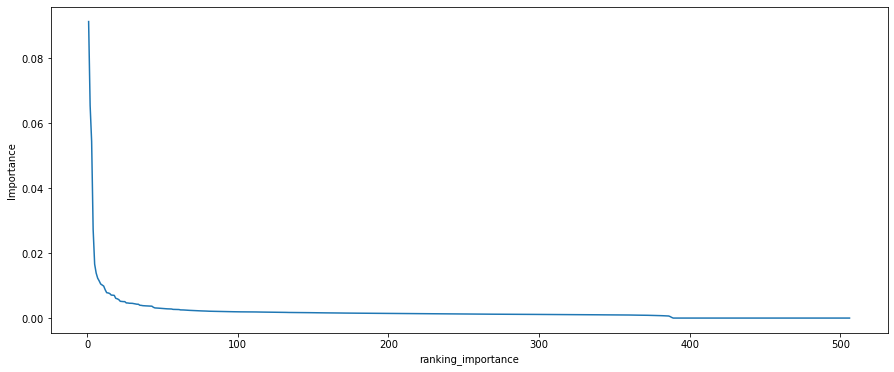

In [16]:
plt.figure(figsize = (15,6))
sns.lineplot(data = feature_importances_df, x = 'ranking_importance', y = 'Importance')
plt.show()

In [17]:
feature_importances_df

,feature,Importance,ranking_importance
403,ivr_last_dept_Retention,0.091284,1
484,tot_retention_contacts_m0,0.065456,2
220,agent_last_dept_Retention,0.054373,3
227,tenure_productclass_morethan_60mon_VIDEO/OOL/OV,0.027280,4
497,flag_comp_FIBER,0.016594,5
...,...,...,...
381,agent_repeat_2_prevInteractionReason_Video,0.000000,502
382,agent_repeat_2_prevInteractionReason_General,0.000000,503
383,agent_repeat_2_prevInteractionReason_Appointment,0.000000,504
384,agent_repeat_2_prevInteractionReason_Phone,0.000000,505


In [18]:
best_nb = 215 # top 215 features gave 70% information
best_features = list(feature_importances_df[0:215]['feature'])

In [19]:
best_features

['ivr_last_dept_Retention',
 'tot_retention_contacts_m0',
 'agent_last_dept_Retention',
 'tenure_productclass_morethan_60mon_VIDEO/OOL/OV',
 'flag_comp_FIBER',
 'ivr_last_interactionReason_Retention',
 'head_end_desc_BRIDGEPORT',
 'agentlastdep_OFFLINEdistress_Retention_1',
 'curr_video_tier_desc_m0_BASIC',
 'videopromo_rng_m0_d: 12-13',
 'oolpromo_rng_m0_a: 0-2',
 'cust_tenure_morethan_60mon',
 'agent_offered_30day',
 'agentlastdep_WIFIQoEdistress_Retention_0',
 'local_market_segment_LIE',
 'local_market_segment_North Atlantic',
 'speed_m0_50',
 'local_market_segment_LIW',
 'agentlastdep_OFFLINEdistress_None_0',
 'curr_video_tier_desc_m0_PREMIER',
 'baserev_change_m6m0_up',
 'head_end_desc_OAKLAND',
 'baserev_change_m6m0_same',
 'oolpromo_rng_m0_d: 12-13',
 'ivr_last_ivrInteractionEndResult_Transfer',
 'flag_comp_DOCSIS_3_1',
 'tot_retention_contacts_m1',
 'head_end_desc_CORAM',
 'ivr_repeat_1_prevInteractionReason_Retention',
 'head_end_desc_CENTRAL ISLIP HAUPPAUGE',
 'cust_equip_cla

## Run model with CV = 3

### get best hyper parameters

In [20]:
start=time.time()
### get best hyper parameters
best_model_after_fs = cm.fixed_churn().grid_search(X_train_down[best_features], y_train_down, cv =  3)
end=time.time()
print ("time_spend: "+str(end-start))

**************************************************
get best hyper parameters

time_spend: 6511.4536345005035


In [21]:
filename = 'fixed_churn_best_model_top215_features_EAST.sav'
pickle.dump(best_model_after_fs, open(filename,'wb'))

In [31]:
# filename = 'fixed_churn_best_model_top215_features_EAST.sav'
# best_model_after_fs = pickle.load(open(filename, 'rb'))

### Model Evaluations

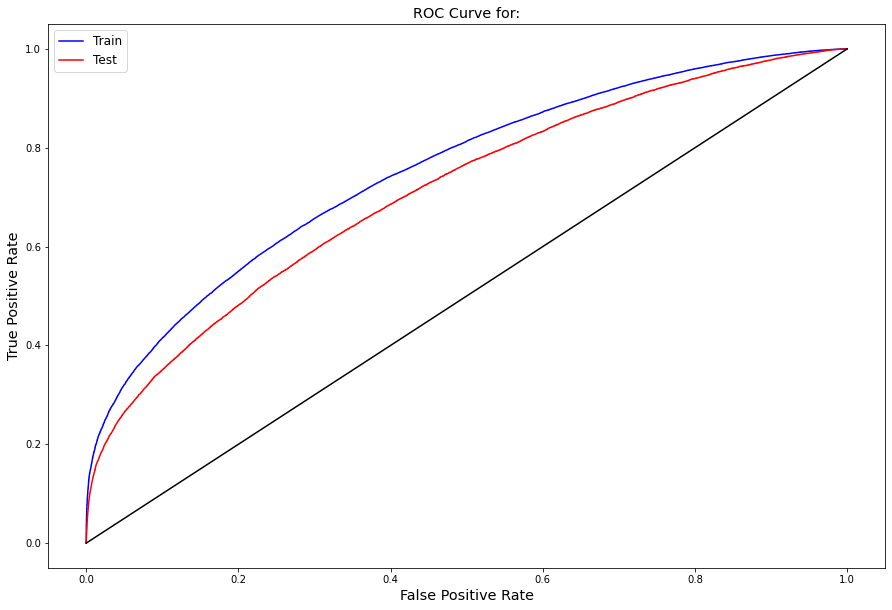

In [22]:
[ metrics_summary, y_test_proba, y_train_proba,y_proba,y_pred]= cm.fixed_churn().model_evaluation (best_model_after_fs,X_train_down[best_features], y_train_down, X_train[best_features], y_train, X_test[best_features], y_test, X[best_features], y)

In [23]:
metrics_summary

,Training down_sample,Training,Testing
Accuracy,0.678450,0.714179,0.712146
Recall,0.610769,0.610769,0.577770
F1-Score,0.655107,0.086706,0.081871


### Lift Analysis

In [28]:
lift_train = cm.fixed_churn().lift_analysis(y_train, y_train_proba)
lift_test  = cm.fixed_churn().lift_analysis(y_test, y_test_proba)
lift_all   = cm.fixed_churn().lift_analysis(y, y_proba)

In [29]:
#### break down lift curve with interval as 5 in the top 20 decile
lift_train_ = cm.fixed_churn().lift_analysis_5(y_train, y_train_proba)
lift_test_  = cm.fixed_churn().lift_analysis_5(y_test, y_test_proba)
lift_all_   = cm.fixed_churn().lift_analysis_5(y, y_proba)

In [30]:
lift_train_final = pd.concat([lift_train_.head(4),lift_train.tail(8)],axis=0).rename(columns={'Lift':'train_lift','share of churn':'train_share of churn'})
lift_test_final  = pd.concat([lift_test_.head(4),lift_test.tail(8)],axis=0).rename(columns={'Lift':'test_lift','share of churn':'test_share of churn'})
lift_all_final   = pd.concat([lift_all_.head(4),lift_all.tail(8)],axis=0).rename(columns={'Lift':'overall_lift','share of churn':'all_share of churn'})

In [31]:
df_lift_final = lift_train_final.merge(lift_test_final, on='Decile',how='inner')\
                .merge(lift_all_final,on='Decile',how='inner')

df_lift_final

,Decile,train_lift,train_share of churn,test_lift,test_share of churn,overall_lift,all_share of churn
0,0% - 5%,5.375789,13044.0,5.089056,4116.0,5.301907,17153.0
1,5% - 10%,1.961708,4760.0,1.769300,1431.0,1.914844,6195.0
2,10% - 15%,1.529391,3711.0,1.383541,1119.0,1.497256,4844.0
3,15% - 20%,1.296129,3145.0,1.243792,1006.0,1.276253,4129.0
4,20% - 30%,1.113563,5404.0,1.126986,1823.0,1.118615,7238.0
5,30% - 40%,0.924805,4488.0,0.931003,1506.0,0.926203,5993.0
6,40% - 50%,0.783244,3801.0,0.830237,1343.0,0.794992,5144.0
7,50% - 60%,0.651979,3164.0,0.674461,1091.0,0.657909,4257.0
8,60% - 70%,0.546890,2654.0,0.591613,957.0,0.557607,3608.0
9,70% - 80%,0.427578,2075.0,0.495181,801.0,0.445251,2881.0


### Score the Training month customers for estimating Retention Calls for each rank

##### We will append this to our scoring list

In [2]:
# Take step4 output and do the scoring

raw_data_res_cpy_step4 = pd.read_pickle("raw_data_res_cpy_step4.pkl") 
raw_data_res_cpy_step4.set_index('chc_id', inplace= True)

In [3]:
## Check missing values
df_missing = pd.DataFrame(raw_data_res_cpy_step4.isnull().sum(), columns = ['missing']) #/raw_data_res_v2[num_cols_v2].shape[0]
df_missing[df_missing['missing'] > 0]

,missing


In [4]:
raw_data_res_cpy_step4.columns = raw_data_res_cpy_step4.columns.str.split('.').str[0]
raw_data_res_cpy_step4.columns

Index(['agentlastdep_OFFLINEdistress_None_0',
       'agentlastdep_OFFLINEdistress_None_1',
       'agentlastdep_OFFLINEdistress_Customer Service Rep_0',
       'agentlastdep_OFFLINEdistress_Technical Service Rep_0',
       'agentlastdep_OFFLINEdistress_Technical Service Rep_1',
       'agentlastdep_OFFLINEdistress_Customer Service Rep_1',
       'agentlastdep_OFFLINEdistress_Retention_0',
       'agentlastdep_OFFLINEdistress_Retention_1',
       'agentlastdep_OFFLINEdistress_Sales_0',
       'agentlastdep_OFFLINEdistress_Sales_1',
       ...
       'flag_comp_FIBER', 'flag_comp_TERRESTRIAL_FIXED', 'OUTCOME_vol_FM',
       'ov_tier_change_m4m0', 'agentcall_and_repeat1', 'agentcall_and_repeat2',
       'agentcall_and_repeat3', 'servicevisit_once', 'servicevisit_twotimes',
       'agentcall_servicevisit'],
      dtype='object', length=507)

In [5]:
filename = 'fixed_churn_best_model_top215_features_EAST.sav'
best_model_after_fs = pickle.load(open(filename, 'rb'))


feature_importances_df = pd.read_csv('best_model_feature_importances_EAST.csv')  
feature_importances_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          506 non-null    int64  
 1   feature             506 non-null    object 
 2   Importance          506 non-null    float64
 3   ranking_importance  506 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 15.9+ KB


In [6]:
best_nb = 215 # top 215 features gave 70% information
best_features = list(feature_importances_df[0:best_nb]['feature'])
len(best_features)

215

In [7]:
# Predict full Data
y_pred_fulldata  = best_model_after_fs.predict(raw_data_res_cpy_step4[best_features])
y_proba_fulldata = best_model_after_fs.predict_proba(raw_data_res_cpy_step4[best_features])[:,1]


## Build final data
df_predict_actual                   = pd.DataFrame()
df_predict_actual['predict']        = y_pred_fulldata
df_predict_actual['predict_prob']   = y_proba_fulldata
df_predict_actual['chc_id']         = raw_data_res_cpy_step4.index

df_predict_actual.head()

,predict,predict_prob,chc_id
0,1,0.679995,784824197902
1,0,0.388669,787004843007
2,0,0.477111,786986075003
3,1,0.501344,786904108703
4,1,0.791518,788113734802


In [8]:
df_fixed    = df_predict_actual.sort_values(by = 'predict_prob', ascending = False).reset_index()
sample_size = df_predict_actual.shape[0]

decile_size = sample_size/100
df_fixed['Rank'] = ((df_predict_actual.index//decile_size)*1+1).astype('int64')

df_fixed2 = df_fixed[df_fixed['Rank'] <= 20][['chc_id', 'Rank']]
df_fixed2.head()

,chc_id,Rank
0,780134612105,1
1,782803020603,1
2,780129946104,1
3,785882820002,1
4,780136183503,1


#### Get the Retention Calls for ranks 1-20 from above scored list

In [9]:
# Set up the connection to GBG
bqconn = cpp.bqConnect('alticeusa-am-b639e404289b.json', 'alticeusa-am')

# Read the retention calls data
retention_calls_sql = '''select chc_id, reportdate from `eds_churn.fc_retention_calls` where reportdate >= '2022-02-01' and reportdate < '2022-06-01' '''

retention_calls = bqconn.fetch_data(retention_calls_sql)
print('Shape of retention calls : ', retention_calls.shape)

Shape of retention calls :  (1082083, 2)


In [10]:
# Read the training month data to get the OUTCOME_VOL_DISCO_ORDER_DATE
current_month_sql = '''select chc_id, OUTCOME_VOL_DISCO_ORDER_DATE from eds_churn.t_ds_fixed_churn_train where month_id = '202202' and upper(cust_class_fs_type_desc) = 'RESIDENTIAL' and metro_area_id = 401 '''
current_month_data = bqconn.fetch_data(current_month_sql)
print('Shape of training month data : ', current_month_data.shape)

Shape of training month data :  (2912819, 2)


In [11]:
top20_chc_wordt = df_fixed2.merge(current_month_data, on='chc_id',how='left') 
print('Count of top 20% customers                              : ', top20_chc_wordt.shape[0])
print('Customers from top 20% who ordered Volunatry disconnect : ', top20_chc_wordt['OUTCOME_VOL_DISCO_ORDER_DATE'].count())
top20_chc_wordt.head()

Count of top 20% customers                              :  582564
Customers from top 20% who ordered Volunatry disconnect :  23252


,chc_id,Rank,OUTCOME_VOL_DISCO_ORDER_DATE
0,780134612105,1,2022-02-17
1,782803020603,1,2022-02-26
2,780129946104,1,2022-02-23
3,785882820002,1,2022-02-18
4,780136183503,1,2022-02-14


In [12]:
top20_ret_calls = top20_chc_wordt.merge(retention_calls, on='chc_id',how='left') 
print('Retention calls from top20% customers : ', top20_ret_calls['reportdate'].count())
top20_ret_calls.head()

Retention calls from top20% customers :  179986


,chc_id,Rank,OUTCOME_VOL_DISCO_ORDER_DATE,reportdate
0,780134612105,1,2022-02-17,2022-02-14
1,782803020603,1,2022-02-26,2022-02-26
2,782803020603,1,2022-02-26,2022-02-28
3,780129946104,1,2022-02-23,2022-02-11
4,780129946104,1,2022-02-23,2022-02-23


In [13]:
top20_ret_calls.loc[(top20_ret_calls['OUTCOME_VOL_DISCO_ORDER_DATE'].isnull()), 'OUTCOME_VOL_DISCO_ORDER_DATE'] = '2022-05-31' #change this date every time you train
top20_ret_calls['OUTCOME_VOL_DISCO_ORDER_DATE'] = top20_ret_calls['OUTCOME_VOL_DISCO_ORDER_DATE'].astype('datetime64[ns]')
print('Null values in OUTCOME_VOL_DISCO_ORDER_DATE : ', top20_ret_calls['OUTCOME_VOL_DISCO_ORDER_DATE'].isnull().sum())
top20_ret_calls.head()

Null values in OUTCOME_VOL_DISCO_ORDER_DATE :  0


,chc_id,Rank,OUTCOME_VOL_DISCO_ORDER_DATE,reportdate
0,780134612105,1,2022-02-17,2022-02-14
1,782803020603,1,2022-02-26,2022-02-26
2,782803020603,1,2022-02-26,2022-02-28
3,780129946104,1,2022-02-23,2022-02-11
4,780129946104,1,2022-02-23,2022-02-23


In [14]:
#change this date every time you train
top20_ret_calls["retention_calls"] = np.where((top20_ret_calls["reportdate"] >= '2022-02-01') & (top20_ret_calls["reportdate"] <= top20_ret_calls["OUTCOME_VOL_DISCO_ORDER_DATE"]), 1, 0)
print('Total Retention Calls : ', top20_ret_calls['retention_calls'].sum())
top20_ret_calls.head()

Total Retention Calls :  176183


,chc_id,Rank,OUTCOME_VOL_DISCO_ORDER_DATE,reportdate,retention_calls
0,780134612105,1,2022-02-17,2022-02-14,1
1,782803020603,1,2022-02-26,2022-02-26,1
2,782803020603,1,2022-02-26,2022-02-28,0
3,780129946104,1,2022-02-23,2022-02-11,1
4,780129946104,1,2022-02-23,2022-02-23,1


In [15]:
top20_chc_ret_calls = top20_ret_calls.groupby(['chc_id','Rank']).agg({'retention_calls': 'sum'}).reset_index()
print('Count of top 20% customers : ', top20_chc_ret_calls.shape[0])

# top20_chc_ret_calls.to_csv('retention_calls_from top20pctl_customers_EAST.csv')
top20_chc_ret_calls.head()

Count of top 20% customers :  582564


,chc_id,Rank,retention_calls
0,780100001010,14,0
1,780100001104,20,0
2,780100001306,9,0
3,780100002312,16,0
4,780100002907,3,0


In [16]:
top20_chc_ret_calls = top20_chc_ret_calls.groupby(['Rank']).agg({'retention_calls':'sum', 'chc_id':'count'}).reset_index()
top20_chc_ret_calls.rename(columns = {'chc_id':'customer_count'}, inplace = True)
top20_chc_ret_calls['retention_callrate'] = round(top20_chc_ret_calls['retention_calls']/top20_chc_ret_calls['customer_count'], 3)

# Write to csv file
top20_chc_ret_calls.to_csv('retention_callrate_from top20pctl_customers_EAST.csv')
top20_chc_ret_calls

,Rank,retention_calls,customer_count,retention_callrate
0,1,36689,29129,1.260
1,2,20653,29128,0.709
2,3,13477,29128,0.463
3,4,10560,29128,0.363
4,5,9007,29128,0.309
5,6,8021,29129,0.275
6,7,7440,29128,0.255
7,8,7034,29128,0.241
8,9,6593,29128,0.226
9,10,6182,29128,0.212


## Validate the model on March data

In [70]:
# Set up the connection to GBG
bqconn = cpp.bqConnect('alticeusa-am-b639e404289b.json', 'alticeusa-am')

# Get the training data for required month (EAST residential customers)
raw_data_sql_validate = '''select * from eds_churn.t_ds_fixed_churn_train where month_id = '202203' and upper(cust_class_fs_type_desc) = 'RESIDENTIAL' and metro_area_id = 401 '''
raw_data_res_validate = bqconn.fetch_data(raw_data_sql_validate)

raw_data_res_validate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2908624 entries, 0 to 2908623
Columns: 272 entries, month_id to OUTCOME_false_mover_flag
dtypes: datetime64[ns](18), float64(55), int64(23), object(176)
memory usage: 5.9+ GB


In [71]:
raw_data_res_validate.head().T

,0,1,2,3,4
month_id,202203,202203,202203,202203,202203
curr_dt,2022-03-31,2022-03-31,2022-03-31,2022-03-31,2022-03-31
chc_id,787218255002,780851295519,787097726908,780209359406,783647506205
corp,7872,7808,7870,7802,7836
house,182550,512955,977269,93594,475062
cust,2,19,8,6,5
account_id,33212930,32915525,31191092,32469481,31228554
house_id,13740110,1098101,4850462,533906,1754812
fta,1,2,45,4,97
node_latitude,40.920202,41.059425,40.864153,40.912321,40.666141


##### Create target variable by combining Ord. Vol disco and FM 

In [72]:
raw_data_res_validate["OUTCOME_vol_FM"] = np.where((raw_data_res_validate["OUTCOME_VOL_DISCO_NXT_4MTH"] == 1) | (raw_data_res_validate["OUTCOME_false_mover_flag"] == 1), 1, 0)

print('Pending Voluntary disconnects : ', raw_data_res_validate['OUTCOME_VOL_DISCO_NXT_4MTH'].sum())
print('False Movers                  : ', raw_data_res_validate['OUTCOME_false_mover_flag'].sum())
print('Pend Vol disconnects + False Movers : ', raw_data_res_validate["OUTCOME_vol_FM"].sum())

Pending Voluntary disconnects :  44949
False Movers                  :  22365.0
Pend Vol disconnects + False Movers :  66879


##### Extract only below useful columns for modelling

In [73]:
target_col = ['OUTCOME_vol_FM']

cat_cols = [
'head_end_desc', 'local_market_segment', 
'metro_area_desc', 'product_class_desc', 'cust_equip_class', 
'ecohort_code_desc', 'ecohort_income_range_desc', 'ecohort_age_range_desc', 'ecohort_spending_type_desc', 'ecohort_credit_line_type_desc', 'ecohort_credit_usage_type_desc', 'archetype_desc', 
'ebill_status_desc',
'agent_last_dept',   
'agent_repeat_1_prevDept', 'agent_repeat_1_prevInteractionReason', 'agent_repeat_2_prevDept', 
'agent_repeat_2_prevInteractionReason', 'agent_repeat_3_prevInteractionReason', 'agent_repeat_3_prevDept', 
'ivr_last_dept', 'ivr_last_interactionReason', 'ivr_last_ivrInteractionEndResult', 
'ivr_repeat_1_prevDept', 'ivr_repeat_1_prevInteractionReason',
'ivr_repeat_2_prevDept', 'ivr_repeat_2_prevInteractionReason',
'ivr_repeat_3_prevDept', 'ivr_repeat_3_prevInteractionReason',
'speed_m0', 'speed_m1', 'speed_m2', 'speed_m3', 'speed_m4', 
'curr_video_tier_desc_m0', 'curr_video_tier_desc_m1', 'curr_video_tier_desc_m2', 'curr_video_tier_desc_m3', 'curr_video_tier_desc_m4', 
'curr_ov_tier_desc_m0', 'curr_ov_tier_desc_m1', 'curr_ov_tier_desc_m2', 'curr_ov_tier_desc_m3', 'curr_ov_tier_desc_m4', 
'hbo_svod_new_m1', 'hbo_svod_new_m2', 'hbo_svod_new_m3',
'max_svod_m1', 'max_svod_m2', 'max_svod_m3', 
'ool_offer_group_v2_desc_m0', 'ool_offer_group_v2_desc_m1', 'ool_offer_group_v2_desc_m2', 'ool_offer_group_v2_desc_m3', 'ool_offer_group_v2_desc_m4',
'oolpromo_rng_m0',             
'ov_offer_group_v2_desc_m0', 'ov_offer_group_v2_desc_m1', 'ov_offer_group_v2_desc_m2', 'ov_offer_group_v2_desc_m3', 'ov_offer_group_v2_desc_m4',   
'ovpromo_rng_m0',            
'stz_enc_svod_m1', 'stz_enc_svod_m2', 'stz_enc_svod_m3', 
'video_offer_group_desc_m0', 'video_offer_group_desc_m1', 'video_offer_group_desc_m2', 'video_offer_group_desc_m3', 'video_offer_group_desc_m4', 
'service_visit_1_tc_problem_code_desc', 'service_visit_1_tc_fix_code_desc', 'service_visit_2_tc_problem_code_desc', 'service_visit_2_tc_fix_code_desc', 
'service_visit_3_tc_problem_code_desc', 'service_visit_3_tc_fix_code_desc', 
'videopromo_rng_m0']           


num_cols = [
'analog_revenue',  'iptel_revenue', 'ool_revenue',  'dvr_revenue',
'auto_ind', 
'agent_abandoned_standard_7day', 'agent_abandoned_7day', 'agent_offered_7day', 'agent_accepted_7day', 'agent_abandoned_standard_30day', 'agent_abandoned_30day', 'agent_offered_30day', 'agent_accepted_30day',
'agent_repeat_calls_30day', 'ivr_calls_7day', 'ivr_calls_30day', 'ivr_repeat_calls_30day', 
'service_visits_7day', 'service_visits_30day', 'service_visits_90day', 
'outages_90day', 'outages_60day', 'outages_30day', 
'rate_event_count_60day', 
'promo_rolloff_count_60day', 
'FAILSTAT_OFFLINEEVT', 'FAILSTAT_DHCP_MACADDR', 'FAILSTAT_WIFI_REBOOT_COUNT', 'FAILSTAT_WIFI_QOE_HOME_30',
# 'acu_ool_usage_down_mb_m1', 'acu_ool_usage_up_mb_m1', 'acu_ool_usage_down_mb_m2', 'acu_ool_usage_up_mb_m2', 
# 'avg_sports_sc_rev_m1_m6', 
'baserev_m0', 'baserev_m1', 'baserev_m2', 'baserev_m3', 'baserev_m4', 'baserev_m5', 'baserev_m6', 
'cust_svc_bill_agent_offered_m0', 'cust_svc_bill_agent_offered_m1', 'cust_svc_bill_agent_offered_m2', 'cust_svc_bill_agent_offered_m3', 'cust_svc_bill_agent_offered_m4', 'cust_svc_bill_agent_offered_m5', 'cust_svc_bill_agent_offered_m6', 
'tot_ool_gb_all_m1', 'tot_ool_gb_all_m2',
# 'mb_total_usage1', 'mb_total_usage2', 
'roll_off_lift_m0' , 'roll_off_lift_m1', 'roll_off_lift_m2', 'roll_off_lift_m3', 'roll_off_lift_m4',              
'tot_retention_contacts_m0', 'tot_retention_contacts_m1', 'tot_retention_contacts_m2', 'tot_retention_contacts_m3', 'tot_retention_contacts_m4', 
'flag_altice_CABLE', 'flag_altice_DOCSIS_3_0', 'flag_altice_DOCSIS_3_1', 'flag_altice_DSL', 'flag_altice_FIBER', 'flag_altice_OTHER', 
'flag_altice_TERRESTRIAL_FIXED', 'flag_comp_CABLE', 'flag_comp_DOCSIS_3_0', 'flag_comp_DOCSIS_3_1', 'flag_comp_DSL', 'flag_comp_FIBER', 'flag_comp_OTHER', 'flag_comp_TERRESTRIAL_FIXED',
'cust_tenure_days'
]

extra_cols = ['chc_id']

print(len(cat_cols))
print(len(num_cols))

77
70


In [74]:
raw_data_res_validate = raw_data_res_validate[cat_cols + num_cols + target_col + extra_cols]
print('Shape : ', raw_data_res_validate.shape)

raw_data_res_validate.head(5)

Shape :  (2908624, 149)


,head_end_desc,local_market_segment,metro_area_desc,product_class_desc,cust_equip_class,ecohort_code_desc,ecohort_income_range_desc,ecohort_age_range_desc,ecohort_spending_type_desc,ecohort_credit_line_type_desc,ecohort_credit_usage_type_desc,archetype_desc,ebill_status_desc,agent_last_dept,agent_repeat_1_prevDept,agent_repeat_1_prevInteractionReason,agent_repeat_2_prevDept,agent_repeat_2_prevInteractionReason,agent_repeat_3_prevInteractionReason,agent_repeat_3_prevDept,ivr_last_dept,ivr_last_interactionReason,ivr_last_ivrInteractionEndResult,ivr_repeat_1_prevDept,ivr_repeat_1_prevInteractionReason,ivr_repeat_2_prevDept,ivr_repeat_2_prevInteractionReason,ivr_repeat_3_prevDept,ivr_repeat_3_prevInteractionReason,speed_m0,speed_m1,speed_m2,speed_m3,speed_m4,curr_video_tier_desc_m0,curr_video_tier_desc_m1,curr_video_tier_desc_m2,curr_video_tier_desc_m3,curr_video_tier_desc_m4,curr_ov_tier_desc_m0,curr_ov_tier_desc_m1,curr_ov_tier_desc_m2,curr_ov_tier_desc_m3,curr_ov_tier_desc_m4,hbo_svod_new_m1,hbo_svod_new_m2,hbo_svod_new_m3,max_svod_m1,max_svod_m2,max_svod_m3,ool_offer_group_v2_desc_m0,ool_offer_group_v2_desc_m1,ool_offer_group_v2_desc_m2,ool_offer_group_v2_desc_m3,ool_offer_group_v2_desc_m4,oolpromo_rng_m0,ov_offer_group_v2_desc_m0,ov_offer_group_v2_desc_m1,ov_offer_group_v2_desc_m2,ov_offer_group_v2_desc_m3,ov_offer_group_v2_desc_m4,ovpromo_rng_m0,stz_enc_svod_m1,stz_enc_svod_m2,stz_enc_svod_m3,video_offer_group_desc_m0,video_offer_group_desc_m1,video_offer_group_desc_m2,video_offer_group_desc_m3,video_offer_group_desc_m4,service_visit_1_tc_problem_code_desc,service_visit_1_tc_fix_code_desc,service_visit_2_tc_problem_code_desc,service_visit_2_tc_fix_code_desc,service_visit_3_tc_problem_code_desc,service_visit_3_tc_fix_code_desc,videopromo_rng_m0,analog_revenue,iptel_revenue,ool_revenue,dvr_revenue,auto_ind,agent_abandoned_standard_7day,agent_abandoned_7day,agent_offered_7day,agent_accepted_7day,agent_abandoned_standard_30day,agent_abandoned_30day,agent_offered_30day,agent_accepted_30day,agent_repeat_calls_30day,ivr_calls_7day,ivr_calls_30day,ivr_repeat_calls_30day,service_visits_7day,service_visits_30day,service_visits_90day,outages_90day,outages_60day,outages_30day,rate_event_count_60day,promo_rolloff_count_60day,FAILSTAT_OFFLINEEVT,FAILSTAT_DHCP_MACADDR,FAILSTAT_WIFI_REBOOT_COUNT,FAILSTAT_WIFI_QOE_HOME_30,baserev_m0,baserev_m1,baserev_m2,baserev_m3,baserev_m4,baserev_m5,baserev_m6,cust_svc_bill_agent_offered_m0,cust_svc_bill_agent_offered_m1,cust_svc_bill_agent_offered_m2,cust_svc_bill_agent_offered_m3,cust_svc_bill_agent_offered_m4,cust_svc_bill_agent_offered_m5,cust_svc_bill_agent_offered_m6,tot_ool_gb_all_m1,tot_ool_gb_all_m2,roll_off_lift_m0,roll_off_lift_m1,roll_off_lift_m2,roll_off_lift_m3,roll_off_lift_m4,tot_retention_contacts_m0,tot_retention_contacts_m1,tot_retention_contacts_m2,tot_retention_contacts_m3,tot_retention_contacts_m4,flag_altice_CABLE,flag_altice_DOCSIS_3_0,flag_altice_DOCSIS_3_1,flag_altice_DSL,flag_altice_FIBER,flag_altice_OTHER,flag_altice_TERRESTRIAL_FIXED,flag_comp_CABLE,flag_comp_DOCSIS_3_0,flag_comp_DOCSIS_3_1,flag_comp_DSL,flag_comp_FIBER,flag_comp_OTHER,flag_comp_TERRESTRIAL_FIXED,cust_tenure_days,OUTCOME_vol_FM,chc_id
0,PATERSON,NORTH NJ,NYMA,OOL,ALTICE GATEWAY,Not Assigned,Not Assigned,Not Assigned,Not Assigned,Not Assigned,Not Assigned,NA,Ebill Only,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,OPTIMUM 500,OPTIMUM 500,OPTIMUM 500,OPTIMUM 500,None,OTHER,OTHER,OTHER,OTHER,None,Other,Other,Other,Other,None,N,N,N,N,N,N,$89.99 Promo-12,$89.99 Promo-12,$89.99 Promo-12,$89.99 Promo-12,None,c: 6-11,No Offer,No Offer,No Offer,No Offer,None,None,N,N,N,No Offer,No Offer,No Offer,No Offer,None,None,None,None,None,None,None,None,0E-9,0E-9,36.990000000,0E-9,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,NaN,NaN,1,1,1,0,49.990000000,49.990000000,49.990000000,52.990000000,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,None,None,None,None,

### Pre-Processing

In [75]:
raw_data_res_validate_cpy = raw_data_res_validate.copy()

#### Step1 : Reduce levels

In [77]:
raw_data_res_validate_cpy[cat_cols] = raw_data_res_validate_cpy[cat_cols].fillna(value='None')
dict1 = cpp.reduce_cat_cols_levels(raw_data_res_validate_cpy, cat_cols, num_cols)

ebill_status_desc ======================
Before :  ['Ebill Only' 'Not Ebill' 'Ebill And Print Statement' 'None']
After  :  ['Ebill' 'Not Ebill' 'None']

agent_last_dept ======================
Before :  ['None' 'Customer Service Rep' 'Sales' 'Technical Service Rep'
 'Retention BPO' 'Retention L1' 'Retention MT' 'Retention L2 ESC'
 'Retention L2 SBR' 'Shared Services' 'Sales Support' 'Sales Commercial'
 'Retention Commercial' 'Ecommerce Sales' 'West Sales Support'
 'Billing and Collections']
After  :  ['None' 'Customer Service Rep' 'Sales' 'Technical Service Rep' 'Retention'
 'Shared Services' 'Billing and Collections']

 ivr_last_dept ======================
Before :  ['None' 'Customer Service Rep' 'Retention' 'Technical Service Rep'
 'Retention BPO' 'Retention L1' 'Sales' 'Unknown' 'Retention MT'
 'Retention L2 SBR' 'Retention Escalation' 'Sales Commercial'
 'Retention L2 ESC' 'Retention Commercial' 'Ecommerce Sales'
 'Sales Support' 'Shared Services' 'Direct Sales']
After  :  ['None' '

In [78]:
cat_cols_step1 = dict1['final_cat_cols']
num_cols_step1 = dict1['final_num_cols']

print(len(cat_cols_step1))
print(len(num_cols_step1))

raw_data_res_validate_cpy_step1 = dict1['df']
raw_data_res_validate_cpy_step1.shape

47
92


(2908624, 141)

In [79]:
raw_data_res_validate_cpy_step1.to_pickle('raw_data_res_validate_cpy_step1.pkl')

# raw_data_res_cpy_step1 = pd.read_pickle("raw_data_res_cpy_step1.pkl")  
# raw_data_res_cpy_step1.info()

file_name1 = "cat_cols_validate_step1.pkl"

open_file1 = open(file_name1, "wb")
pickle.dump(cat_cols_step1, open_file1)
open_file1.close()

# open_file1 = open(file_name1, "rb")
# cat_cols_step1 = pickle.load(open_file1)
# open_file1.close()

file_name2 = "num_cols_validate_step1.pkl"

open_file2 = open(file_name2, "wb")
pickle.dump(num_cols_step1, open_file2)
open_file2.close()

# open_file2 = open(file_name2, "rb")
# num_cols_step1 = pickle.load(open_file2)
# open_file2.close()

### Step2 : Rare Category encoding Categorical columns

In [80]:
raw_data_res_cpy_step2 = pd.read_pickle("raw_data_res_cpy_step2_train_EAST.pkl")  
raw_data_res_cpy_step2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2912819 entries, 0 to 2912818
Columns: 141 entries, head_end_desc to agentlastdep_WIFIQoEdistress
dtypes: float64(49), int32(6), int64(30), object(54), string(2)
memory usage: 3.0+ GB


In [81]:
features_rarecat_enc = ['head_end_desc','ecohort_code_desc']

raw_data_res_validate_cpy_step2 = raw_data_res_validate_cpy_step1.copy()

for col in features_rarecat_enc:
    lst = list(raw_data_res_cpy_step2[col].unique())
    raw_data_res_validate_cpy_step2.loc[~(raw_data_res_validate_cpy_step2[col].isin(lst)), col] = 'ALL_OTHER' 

In [83]:
raw_data_res_validate_cpy_step2[features_rarecat_enc].describe()

,head_end_desc,ecohort_code_desc
count,2908624,2908624
unique,21,21
top,ALL_OTHER,ALL_OTHER
freq,1410534,1019660


### Step3: Preprocess numerical columns

##### 1. Replace max values with upper_quant percentile and min value with lower_quant percentile
##### 2. Replace negative values with 0
##### 3. Remove features with constatnt values 
##### 4. Replace missing values with 0

In [84]:
dict2 = cpp.preprocess_num_cols(raw_data_res_validate_cpy_step2, num_cols_step1, replace_neg_values = True, remove_constant_features = False, lower_quant = 0, upper_quant = 0.995)

1. Replaced max values with lower_quant and upper_quant percentiles
2. Replaced negative values with 0
4. Replaced missing values with 0


In [85]:
num_cols_step3 = dict2['num_cols_remain']
const_cols_removed_step3 = dict2['const_cols_removed']

print(len(num_cols_step3))
print(len(const_cols_removed_step3))

raw_data_res_validate_cpy_step3 = dict2['df']
raw_data_res_validate_cpy_step3.shape

92
0


(2908624, 141)

In [86]:
# No missing values found
raw_data_res_validate_cpy_step3[list(set(num_cols_step3) - set(const_cols_removed_step3))].isnull().sum()

outages_60day                           0
iptel_revenue                           0
promo_rolloff_count_60day               0
flag_altice_DOCSIS_3_1                  0
ivr_repeat_calls_30day                  0
agent_abandoned_standard_7day           0
agentcall_servicevisit                  0
tot_retention_contacts_m3               0
ov_offer_group_v2_desc_m3               0
roll_off_lift_m4                        0
service_visit_3_tc_problem_code_desc    0
dvr_revenue                             0
cust_svc_bill_agent_offered_m3          0
roll_off_lift_m1                        0
flag_comp_CABLE                         0
flag_altice_FIBER                       0
service_visit_3_tc_fix_code_desc        0
ool_revenue                             0
ivr_calls_30day                         0
flag_comp_DSL                           0
ool_offer_group_v2_desc_m3              0
flag_altice_DSL                         0
flag_altice_TERRESTRIAL_FIXED           0
rate_event_count_60day            

### Step4: One hot encoding of Categorical columns

In [88]:
fit_ohe_validate   = cpp.UniversalCategoryEncoder(encoding_method='ohe').fit(X = raw_data_res_validate_cpy_step3, features_CAT_ = cat_cols_step1)
dict3_validate     = fit_ohe_validate.transform(X = raw_data_res_validate_cpy_step3)

In [89]:
X_ohe_step4 = dict3_validate['X_transformed']
X_ohe_step4.shape

(2908624, 425)

In [91]:
raw_data_res_validate_cpy_step4 = dict3_validate['X_full']
raw_data_res_validate_cpy_step4.shape

(2908624, 519)

In [93]:
raw_data_res_validate_cpy_step4.to_pickle('raw_data_res_validate_cpy_step4.pkl')

### Prediction

In [2]:
raw_data_res_validate_cpy_step4 = pd.read_pickle("raw_data_res_validate_cpy_step4.pkl")  

In [3]:
raw_data_res_validate_cpy_step4.set_index('chc_id', inplace= True)

In [4]:
## Check missing values
df_missing = pd.DataFrame(raw_data_res_validate_cpy_step4.isnull().sum(), columns = ['missing'])
df_missing[df_missing['missing'] > 0]

,missing


In [5]:
raw_data_res_validate_cpy_step4.columns = raw_data_res_validate_cpy_step4.columns.str.split('.').str[0]
raw_data_res_validate_cpy_step4.columns

Index(['ovpromo_rng_m0_None', 'ovpromo_rng_m0_b: 3-5', 'ovpromo_rng_m0_a: 0-2',
       'ovpromo_rng_m0_c: 6-11', 'ovpromo_rng_m0_d: 12-13',
       'ovpromo_rng_m0_g: 22+', 'ovpromo_rng_m0_f: 16-21',
       'ovpromo_rng_m0_e: 14-15', 'head_end_desc_ALL_OTHER',
       'head_end_desc_HICKSVILLE',
       ...
       'OUTCOME_vol_FM', 'ov_tier_change_m4m0', 'rateevent_baserevchange',
       'agentcall_and_repeat1', 'agentcall_and_repeat2',
       'agentcall_and_repeat3', 'servicevisit_once', 'servicevisit_twotimes',
       'servicevisit_threetimes', 'agentcall_servicevisit'],
      dtype='object', length=518)

### Model Evaluations

In [6]:
filename = 'fixed_churn_best_model_top215_features_EAST.sav'
best_model_after_fs = pickle.load(open(filename, 'rb'))

In [7]:
feature_importances_df = pd.read_csv('best_model_feature_importances_EAST.csv')  
feature_importances_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          506 non-null    int64  
 1   feature             506 non-null    object 
 2   Importance          506 non-null    float64
 3   ranking_importance  506 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 15.9+ KB


In [8]:
best_nb = 215 # top 215 features gave 70% information
best_features = list(feature_importances_df[0:best_nb]['feature'])
len(best_features)

215

In [9]:
raw_data_res_validate_cpy_step4[best_features].head(5)

,ivr_last_dept_Retention,tot_retention_contacts_m0,agent_last_dept_Retention,tenure_productclass_morethan_60mon_VIDEO/OOL/OV,flag_comp_FIBER,ivr_last_interactionReason_Retention,head_end_desc_BRIDGEPORT,agentlastdep_OFFLINEdistress_Retention_1,curr_video_tier_desc_m0_BASIC,videopromo_rng_m0_d: 12-13,oolpromo_rng_m0_a: 0-2,cust_tenure_morethan_60mon,agent_offered_30day,agentlastdep_WIFIQoEdistress_Retention_0,local_market_segment_LIE,local_market_segment_North Atlantic,speed_m0_50,local_market_segment_LIW,agentlastdep_OFFLINEdistress_None_0,curr_video_tier_desc_m0_PREMIER,baserev_change_m6m0_up,head_end_desc_OAKLAND,baserev_change_m6m0_same,oolpromo_rng_m0_d: 12-13,ivr_last_ivrInteractionEndResult_Transfer,flag_comp_DOCSIS_3_1,tot_retention_contacts_m1,head_end_desc_CORAM,ivr_repeat_1_prevInteractionReason_Retention,head_end_desc_CENTRAL ISLIP HAUPPAUGE,cust_equip_class_speedm0_LEGACY_50,ool_offer_group_v2_desc_m0,videopromo_rng_m0_a: 0-2,tenure_productclass_0_6mon_VIDEO/OOL/OV,ool_offer_group_v2_desc_m2,speed_m0_25,roll_off_lift_m0,FAILSTAT_OFFLINEEVT,agentlastdep_WIFIRebootdistress_None_0,video_tier_change_m4m0_higher,cust_equip_class_speedm0_LEGACY_25,product_class_desc_OOL,agent_accepted_7day,agentlastdep_WIFIRebootdistress_Retention_0,archetype_desc_Indulgent Empty Nesters,local_market_segment_BROOKLYN,video_offer_group_desc_m3,curr_video_tier_desc_m0_SELECT,roll_off_lift_m1,speed_m0_ALL_OTHER,local_market_segment_CT,tenure_productclass_morethan_60mon_VIDEO/OOL,tenure_productclass_24_60mon_VIDEO/OOL,tenure_income_morethan_60mon_Elite,cust_equip_class_speedm0_LEGACY_0,agentlastdep_OFFLINEdistress_Customer Service Rep_1,head_end_desc_ST,head_end_desc_BROOKLYN - HUB M (ST,head_end_desc_NORWALK,ov_offer_group_v2_desc_m0,ov_offer_group_v2_desc_m2,stz_enc_svod_change_m3m1_down,head_end_desc_ALL_OTHER,product_class_desc_VIDEO,product_class_desc_VIDEO/OOL/OV,cust_equip_class_speedm0_LEGACY_ALL_OTHER,flag_comp_DSL,head_end_desc_HICKSVILLE,tenure_productclass_0_6mon_VIDEO,agent_repeat_3_prevDept_Customer Service Rep,tot_retention_contacts_m2,baserev_change_m6m0_down,ivr_repeat_2_prevInteractionReason_Retention,local_market_segment_SOUTH NJ,ool_offer_group_v2_desc_m3,ivr_last_interactionReason_General,analog_revenue,agent_offered_7day,ecohort_code_desc_Corner Offices: Executive Urbanites,cust_equip_class_speedm0_LEGACY_100,ool_offer_group_v2_desc_m4,ov_tier_change_m4m0,curr_video_tier_desc_m0_CORE,agentlastdep_OFFLINEdistress_Technical Service Rep_0,ecohort_code_desc_Established Wealth: Suburban Retirees,hbo_svod_change_m3m1_up,archetype_desc_Tech Savvy Singles,iptel_revenue,head_end_desc_BRONX - HUB E (TIFFANY),tenure_productclass_0_6mon_OOL,tenure_productclass_morethan_60mon_VIDEO,speed_change_m4m0_higher,tenure_productclass_12_24mon_VIDEO/OOL,agent_repeat_3_prevInteractionReason_Video,head_end_desc_STAMFORD,agentlastdep_DHCPdistress_Retention_0,dvr_revenue,agentlastdep_OFFLINEdistress_Retention_0,ivr_last_interactionReason_Appointment,ool_offer_group_v2_desc_m1,tenure_productclass_24_60mon_OOL,flag_altice_DOCSIS_3_1,speed_change_m4m0_lower,cust_tenure_24_60mon,cust_tenure_0_6mon,auto_ind,speed_m0_0,agent_accepted_30day,tot_retention_contacts_m3,tenure_income_24_60mon_Elite,ivr_repeat_1_prevInteractionReason_Data,rate_event_count_60day,ov_offer_group_v2_desc_m1,FAILSTAT_WIFI_REBOOT_COUNT,ovpromo_rng_m0_a: 0-2,ivr_last_dept_Sales,ecohort_income_range_desc_Low,ecohort_code_desc_Nest Egg Elders: Older Retirees,curr_video_tier_desc_m0_VALUE,ecohort_income_range_desc_Elite,ov_offer_group_v2_desc_m4,ool_revenue,agent_repeat_2_prevDept_Technical Service Rep,agent_abandoned_30day,cust_equip_class_speedm0_ALTICE GATEWAY_400,head_end_desc_BRONX - HUB C&D (JEROME),ecohort_code_desc_Suburban Success: Upscale Families,ivr_repeat_1_prevDept_ALL_OTHER,ecohort_credit_usage_type_desc_Very High,agentcall_and_repeat3,agentlastdep_OFFLINEdistress_None_1,service_visits_7day,ivr_last_interactionReason_Billing,ivr_repeat_2_prevInteractionReason_Video,ten

In [10]:
X_new = raw_data_res_validate_cpy_step4.drop(['OUTCOME_vol_FM'],axis=1)
y_new = raw_data_res_validate_cpy_step4['OUTCOME_vol_FM']

In [11]:
print(X_new.shape)
print(y_new.shape)

(2908624, 517)
(2908624,)


In [12]:
y_new.sum()

66879

In [13]:
y_new.sum()*100/X_new.shape[0]

2.2993346682142484

### Model Evaluations

In [14]:
raw_data_res_cpy_step4 = pd.read_pickle("raw_data_res_cpy_step4.pkl")  
raw_data_res_cpy_step4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2912819 entries, 0 to 2912818
Columns: 508 entries, agentlastdep_OFFLINEdistress_None_0 to agentcall_servicevisit
dtypes: float64(86), int64(422)
memory usage: 11.0 GB


In [15]:
raw_data_res_cpy_step4.set_index('chc_id', inplace= True)
raw_data_res_cpy_step4.columns = raw_data_res_cpy_step4.columns.str.split('.').str[0]

X = raw_data_res_cpy_step4.drop(['OUTCOME_vol_FM'],axis=1)
y = raw_data_res_cpy_step4['OUTCOME_vol_FM']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=24)
train = pd.concat([X_train,y_train], axis = 1)

## Downsampling
[X_train_down, y_train_down] = cm.fixed_churn().downsampling(train, feature='OUTCOME_vol_FM')

**************************************************
Downsampling to make the balanced dataset for modelling



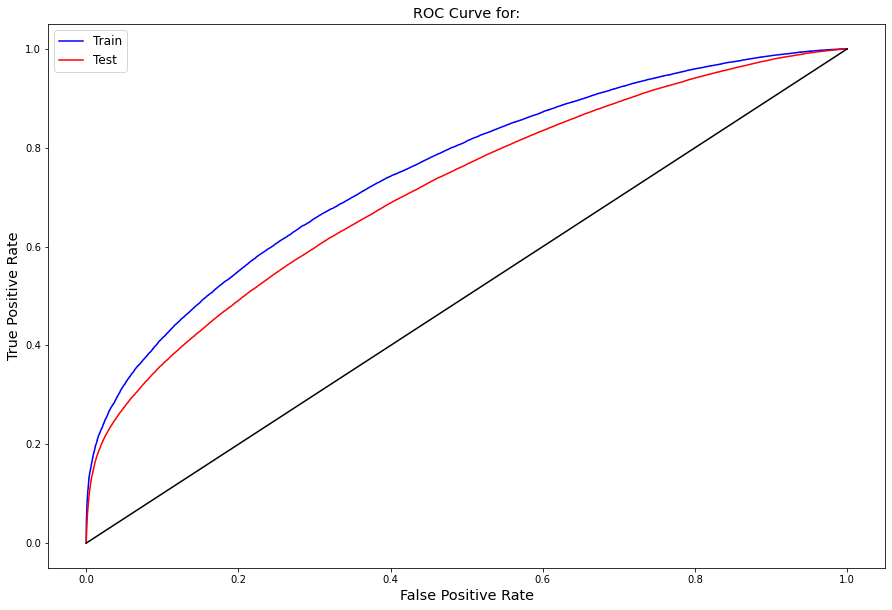

In [16]:
[ metrics_summary, y_test_proba, y_train_proba,y_proba,y_pred]= cm.fixed_churn().model_evaluation (best_model_after_fs, X_train_down[best_features], y_train_down, X_train[best_features], y_train, X_new[best_features], y_new, X[best_features], y)

In [17]:
metrics_summary

,Training down_sample,Training,Testing
Accuracy,0.678450,0.714179,0.707716
Recall,0.610769,0.610769,0.587225
F1-Score,0.655107,0.086706,0.084577


### Lift Analysis

In [19]:
lift_test_10 = cm.fixed_churn().lift_analysis(y_new, y_test_proba)
lift_test_5  = cm.fixed_churn().lift_analysis_5(y_new, y_test_proba)
lift_test_1  = cm.fixed_churn().lift_analysis_1(y_new, y_test_proba)
lift_test_final  = pd.concat([lift_test_1.head(5), lift_test_5.iloc[[1,2,3]],lift_test_10.tail(8)],axis=0).rename(columns={'Lift':'test_lift','share of churn':'test_share_of_churn'})
lift_test_final['test_share_of_churn_%'] = round(lift_test_final['test_share_of_churn']*100/sum(lift_test_final['test_share_of_churn']), 0)
lift_test_final

,Decile,test_lift,test_share_of_churn,test_share_of_churn_%
0,0% - 1%,13.285296,8885.0,13.0
1,1% - 2%,5.206461,3482.0,5.0
2,2% - 3%,3.359827,2247.0,3.0
3,3% - 4%,2.483525,1661.0,2.0
4,4% - 5%,2.189046,1464.0,2.0
1,5% - 10%,1.750029,5852.0,9.0
2,10% - 15%,1.375321,4599.0,7.0
3,15% - 20%,1.232966,4123.0,6.0
2,20% - 30%,1.077171,7204.0,11.0
3,30% - 40%,0.917775,6138.0,9.0
